# **Stage 1**: Train PPO on PointMaze with standard rewards, collect data, train distance models


In [1]:
import gymnasium as gym
import gymnasium_robotics
import numpy as np
import torch
import os

import sys
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))
from src.env_wrappers import EnvBuilder
from src import ppo_agent, distance_models
from src.utils import trajectories_to_dataset

# Check for GPU
print("CUDA available:", torch.cuda.is_available())
print("Current device:", torch.cuda.current_device())
print("Device name:", torch.cuda.get_device_name(torch.cuda.current_device()) if torch.cuda.is_available() else "CPU")

CUDA available: True
Current device: 0
Device name: NVIDIA GeForce RTX 4080 Laptop GPU


In [ ]:
env_id = 'PointMaze_UMaze-v3'  # Use dense reward for initial training
train_episodes = 10000
max_episode_steps = 512
seed = 0

torch.manual_seed(seed); np.random.seed(seed)
gym.register_envs(gymnasium_robotics)

# Initialize environment
c = 'c'; U_map = [
    [1, 1, 1, 1, 1],
    [1, c, 0, 0, 1],
    [1, 1, 1, 0, 1],
    [1, c, 0, 0, 1],
    [1, 1, 1, 1, 1]
]
builder = EnvBuilder(env_id=env_id, maze_map=U_map, max_episode_steps=max_episode_steps, seed=seed)
obs_dim, act_dim = builder.get_obs_act_dim()
agent = ppo_agent.PPOAgent(state_dim=obs_dim, action_dim=act_dim, wandb_name="stage1")

wandb: Currently logged in as: voronov_artem_lit (voronov_artem_lit-skolkovo-institute-of-science-and-tech) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb: WARNING Tried to log to step 0 that is less than the current step 10001. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 1 that is less than the current step 10001. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 2 that is less than the current step 10001. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 3 that is less than the current step 10001. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 4 that is less than the current step 10001. Steps must be monotonically increasing, so this data will be ignored. See ht

In [ ]:
# model_path = "models/ppo_agent_stage1_good.pth"
# agent.ac.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [4]:
# Train
env = builder()
agent.train_ppo(env, num_episodes=train_episodes, max_episode_steps=max_episode_steps)

Training: 100%|███████████████████████████████████████████████| 10000/10000 [31:11<00:00,  5.34it/s]


In [16]:
# Evaluate
U_map = [
    [1, 1, 1, 1, 1],
    [1, c, c, c, 1],
    [1, 1, 1, c, 1],
    [1, c, c, c, 1],
    [1, 1, 1, 1, 1]
]
eval_env = builder(maze_map=U_map)

trajectories = agent.evaluate_ppo(eval_env)
torch.save(agent.ac.state_dict(), "models/ppo_agent_stage1.pth")

eval_env.demonstrate(agent)

Evaluating: 100%|█████████████████████████████████████████████████| 100/100 [00:02<00:00, 35.16it/s]


Over 100 eval episodes, 59 were successful (59.0%)


___

## Generate dataset
___

In [17]:
dataset = trajectories_to_dataset(trajectories)

Building dataset: 100%|█████████████████████████████████████████| 100/100 [00:00<00:00, 1460.05it/s]


Trajectories processed : 100
Generated samples      : 2586915 (train 2069532 / eval 517383)


In [18]:
sup_model = distance_models.SupervisedDistanceEstimator(input_dim=4)
sup_loss = sup_model.train_from_data(dataset, epochs=50, batch_size=16192)
eval_loss = sup_model.evaluate_from_data(dataset, save_model=True, save_path="models/distance_model_sup.pth")

Training, t_loss=0.00:   0%|                                                 | 0/50 [00:00<?, ?it/s]

Training, t_loss=0.00: 100%|████████████████████████████████████████| 50/50 [00:19<00:00,  2.61it/s]


eval_losses[0]=6.092926957640665 -> eval_losses[-1]=4.12020847663264
Eval loss: 4.1202


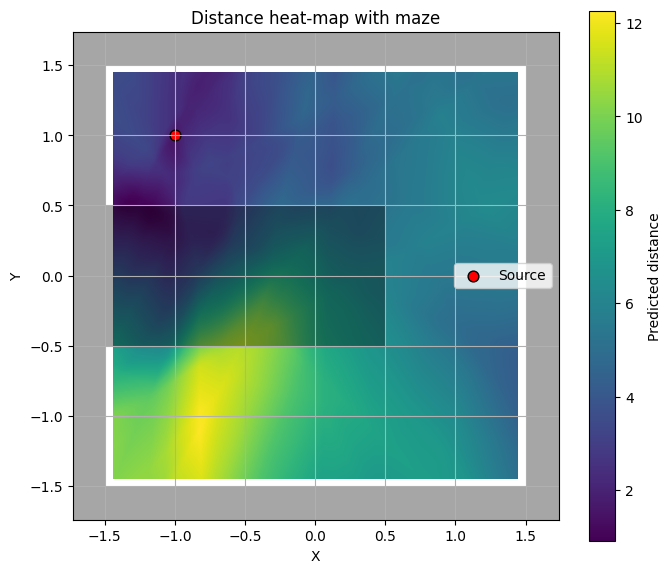

In [20]:
sup_model.plot_distance_heatmap(env=eval_env, source_point=(-1, 1))